<a href="https://colab.research.google.com/github/carminesant1/credit_scoring/blob/main/credit_scoring(modelling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import shap

In [37]:
!git clone https://github.com/carminesant1/credit_scoring.git


Cloning into 'credit_scoring'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 1.74 MiB | 5.49 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [36]:
df = pd.read_csv('/content/credit_scoring/credit_scoring_preprocessed.csv')
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,STATUS_EMPLOYED,AGE
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Other,2,0,Employed,32
1,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2,0,Employed,58
2,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1,1,Employed,52
3,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Pensioner,1,0,Pensioner,61
4,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,1,Accountants,2,0,Employed,46


# Encoding delle variabili categoriali

In [17]:
print(df['CODE_GENDER'].value_counts())
map_gen = {'M':1, 'F':0}
df['CODE_GENDER'] = df['CODE_GENDER'].map(map_gen)

CODE_GENDER
F    44614
M    25160
Name: count, dtype: int64


In [18]:
print(df['FLAG_OWN_CAR'].value_counts())
map_gen = {'Y':1, 'N':0}
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map(map_gen)

FLAG_OWN_CAR
N    43207
Y    26567
Name: count, dtype: int64


In [19]:
print(df['FLAG_OWN_REALTY'].value_counts())
map_gen = {'Y':1, 'N':0}
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map(map_gen)

FLAG_OWN_REALTY
Y    46643
N    23131
Name: count, dtype: int64


In [20]:
print(df['STATUS_EMPLOYED'].value_counts())
map_gen = {'Employed':1, 'Pensioner':0}
df['STATUS_EMPLOYED'] = df['STATUS_EMPLOYED'].map(map_gen)

STATUS_EMPLOYED
Employed     61257
Pensioner     8517
Name: count, dtype: int64


In [21]:
df = pd.get_dummies(df, columns = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'])
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,...,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Pensioner,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,1,1,1,0,427500.0,1,1,0,0,2,...,False,False,True,False,False,False,False,False,False,False
1,1,1,1,0,112500.0,1,0,0,0,2,...,False,False,False,False,False,False,False,False,True,False
2,0,0,1,0,270000.0,1,0,1,1,1,...,False,False,False,False,False,False,True,False,False,False
3,0,0,1,0,283500.0,1,0,0,0,1,...,False,False,False,True,False,False,False,False,False,False
4,1,1,1,0,270000.0,1,1,1,1,2,...,False,False,False,False,False,False,False,False,False,False


# MODELLO

In [22]:
X = df.drop(['TARGET'], axis = 1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=42)

Ho controllato se la variabile TARGET presentasse uno sbilanciamento delle classi

In [23]:
df['TARGET'].value_counts()

,count
TARGET,
0,62536
1,7238


Avendo constatato che la variabile TARGET è composta da classi sbilanciate, ho confrontato diverse alternative:

1) parametro class_weight = "balanced"

2) SMOTE

3) Undersampling casuale

In [26]:
#oversampling
smote = SMOTE(random_state=42)
X_train_ov, y_train_ov = smote.fit_resample(X_train, y_train)
#undersampling
rnd = RandomUnderSampler(random_state=42)
X_train_un, y_train_un = rnd.fit_resample(X_train, y_train)

ss = StandardScaler()

X_train[['AMT_INCOME_TOTAL', 'AGE']]  = ss.fit_transform(X_train[['AMT_INCOME_TOTAL', 'AGE']])
X_train = X_train.values

X_train_ov[['AMT_INCOME_TOTAL', 'AGE']]  = ss.fit_transform(X_train_ov[['AMT_INCOME_TOTAL', 'AGE']])
X_train_ov = X_train_ov.values

X_train_un[['AMT_INCOME_TOTAL', 'AGE']]  = ss.fit_transform(X_train_un[['AMT_INCOME_TOTAL', 'AGE']])
X_train_un = X_train_un.values

X_test[['AMT_INCOME_TOTAL', 'AGE']] = ss.transform(X_test[['AMT_INCOME_TOTAL', 'AGE']])
X_test = X_test.values

y_train = y_train.values
y_train_ov = y_train_ov.values
y_train_un = y_train_un.values

y_test = y_test.values

Ho utilizzato come modello l'algoritmo delle Random Forests

In [27]:
forest = RandomForestClassifier(100,class_weight='balanced',random_state=42)

Ho definito una funzione che mostra le principali misure di valutazione di un modello di machine learning con task di classificazione

In [28]:
def classifier_report(model, X_train, X_test, y_train, y_test):
  print(model)
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  print('Train set')
  precision_class_0 = round(precision_score(y_train, y_train_pred, pos_label=0),2)
  precision_class_1 = round(precision_score(y_train, y_train_pred, pos_label=1),2)
  train_accuracy = round(accuracy_score(y_train, y_train_pred),2)
  print(f'Train accuracy: {train_accuracy}')
  print('Test set')
  precision_class_0 = round(precision_score(y_test, y_test_pred, pos_label=0),2)
  precision_class_1 = round(precision_score(y_test, y_test_pred, pos_label=1),2)
  recall_class_0 = round(recall_score(y_test, y_test_pred, pos_label=0),2)
  recall_class_1 = round(recall_score(y_test, y_test_pred, pos_label=1),2)
  test_accuracy = round(accuracy_score(y_test, y_test_pred),2)
  print(f'Precision class 0: {precision_class_0}')
  print(f'Precision class 1: {precision_class_1}')
  print(f'Recall class 0: {recall_class_0}')
  print(f'Recall class 1: {recall_class_1}')
  print(f'Accuracy: {test_accuracy}')

RISULTATI



In [29]:
print('ORIGINAL DATA')
classifier_report(model=forest,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)

print('-----')

print('OVERSAMPLING')
classifier_report(model=forest,X_train=X_train_ov,X_test=X_test,y_train=y_train_ov,y_test=y_test)

print('-----')

print('UNDERSAMPLING')
classifier_report(model=forest,X_train=X_train_un,X_test=X_test,y_train=y_train_un,y_test=y_test)


ORIGINAL DATA
RandomForestClassifier(class_weight='balanced', random_state=42)
Train set
Train accuracy: 0.95
Test set
Precision class 0: 0.91
Precision class 1: 0.31
Recall class 0: 0.96
Recall class 1: 0.17
Accuracy: 0.87
-----
OVERSAMPLING
RandomForestClassifier(class_weight='balanced', random_state=42)
Train set
Train accuracy: 0.97
Test set
Precision class 0: 0.91
Precision class 1: 0.22
Recall class 0: 0.9
Recall class 1: 0.25
Accuracy: 0.83
-----
UNDERSAMPLING
RandomForestClassifier(class_weight='balanced', random_state=42)
Train set
Train accuracy: 0.97
Test set
Precision class 0: 0.99
Precision class 1: 0.42
Recall class 0: 0.85
Recall class 1: 0.92
Accuracy: 0.86


Dalle misure di valuazione dei modelli si evince che si ottengono migliori performance ricorrendo all'undersampling casuale

In [30]:
forest.fit(X_train_un, y_train_un)

RandomForestClassifier(class_weight='balanced', random_state=42)

#Interpretazione

Feature Importance

In [31]:
# Ottieni l'importanza delle feature
feature_importances = forest.feature_importances_

# Creare un DataFrame per una visualizzazione più leggibile
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualizzare il DataFrame
print(feature_importance_df)


                                              Feature  Importance
11                                                AGE    0.389737
4                                    AMT_INCOME_TOTAL    0.316031
46                          OCCUPATION_TYPE_Pensioner    0.030354
13                         NAME_INCOME_TYPE_Pensioner    0.028939
10                                    STATUS_EMPLOYED    0.022536
9                                     CNT_FAM_MEMBERS    0.017942
3                                        CNT_CHILDREN    0.015110
7                                          FLAG_PHONE    0.011983
1                                        FLAG_OWN_CAR    0.011185
2                                     FLAG_OWN_REALTY    0.010532
0                                         CODE_GENDER    0.009495
43                           OCCUPATION_TYPE_Managers    0.008922
6                                     FLAG_WORK_PHONE    0.008845
8                                          FLAG_EMAIL    0.007982
12        

Algoritmo Shap per ottenere anche un verso della relazione tra la variabile TARGET e le variabili indipendenti

In [32]:
shap_ = shap.TreeExplainer(forest)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
print(X_test_df.shape)

(20933, 53)


A causa dell'elevato costo computazionale dell'algoritmo ho deciso di estrarre casualmenete 5.000 osservazioni dal test set

In [33]:
X_test_df_sample = X_test_df.sample(n=5000, replace = False)
print(X_test_df_sample.shape)

(5000, 53)


In [34]:
shap_val = shap_(X_test_df_sample)

Si conclude che l'affidabilità creditizia è legata a redditi più elevati, correlati ad età ed esperienza lavorativa. Inoltre, si nota che ai pensionati tendono ad avere una bassa affidabilità creditizia.

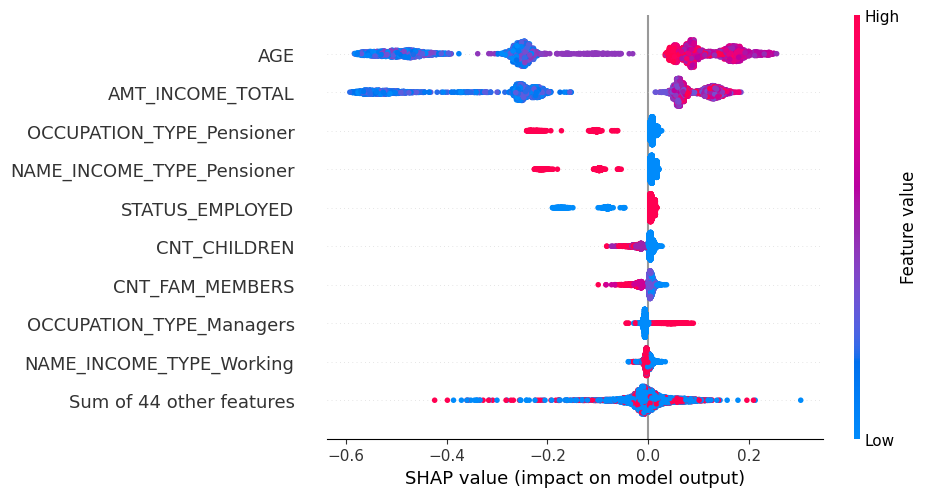

In [35]:
shap.plots.beeswarm(shap_val[:,:,1])